## Overview


There are 3 main steps:
1. Add craters to a base mesh
1. Add rocks to the mesh with craters. This forms a terrain
1. Render the scene. The main rendering settings are:
    - The camera position
    - The sun orientation

This process is repeated for each base mesh, for each terrain and for each rendering setting.


Each dataset is composed of:
- $B$ base meshes
- $T$ terrains
- $R$ rendering settings

![](../../docs/images/2024-08-08-13-00-39.png)

Table of contents:
- [Render an Enhance Moon Terrain Dataset](#render-an-enhance-moon-terrain-dataset)
- [](#using-the-dataset)
- Create a Terrain
    - [](#create-a-rock-field)
    - [](#create-a-crater-field)

## Render an Enhance Moon Terrain Dataset

Call the script generate_enhanced_moon_terrain_dataset with a dataset configuration. 

In [ ]:
!python src/lunasynth/cli/generate_enhanced_moon_terrain_dataset.py \
    --dataset-config config/datasets/ortho_minimal.yaml 

To define the process of batch generation it requires
- a base mesh configuration
- a terrain configuration
    - a crater configuration
    - a rock configuration
- a rendering configuration
- rendering cases configuration
Let's take a look a the default dataset configuration for orthographic images 

In [33]:
!cat ../../config/datasets/ortho_minimal.yaml | yq 

20342.12s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


rendering:
  depth_output: true
  segmentation_output: true
  camera_type: "ORTHO"
  render_engine: CYCLES
  denoise: true
  sampling_render: 64
  resolution_x: 320
  resolution_y: 320
base_mesh:
  meshes: ["/scratch/lunasynth/external_data/pgda78/Haworth_final_adj_5mpp_surf/pieces_2km/Haworth_final_adj_5mpp_surf_piece_12_5.tif"]
  material: "moon_albedo"
name: "minimal"
output:
  save_blender_file: false
  output_root: "/scratch/lunasynth/generated_data/datasets/"
terrain:
  desired_spatial_resolution: 1.0
  samples: 1
  add_rocks: true
  add_craters: true
  rock_field:
    rock_source: 'rocks/generated_100verts'
    h_min: 1.0
    h_max: 10.0
    density:
      type: "uniform"
      min: 0.01
      max: 0.02
  crater_field:
    crater_type: "normal"
    h_min: 1.0
    h_max: 20.0
    density:
      type: "uniform"
      min: 0.1
      max: 0.2
rendering_cases:
  cases: 2
  distributions:
    sun/elevation:
      type: "uniform"
      min: 0.1
      max: 0.2
    sun/azimuth:
      typ

Let's go block by block:

```yaml
rendering:
  depth_output: true # or not
  segmentation_output: true
  camera_type: "ORTHO"
  render_engine: CYCLES
  denoise: true
  sampling_render: 64
  resolution_x: 320
  resolution_y: 320
```
The rendering block defines the rendering settings. The main parameters is the resolution in x and y. The other main parameter is the camera type, which can be "ORTHO" for orthographic or "PERSP" for perspective. 

```yaml
base_mesh:
  meshes: ["/scratch/lunasynth/external_data/pgda78/Haworth_final_adj_5mpp_surf/pieces_2km/Haworth_final_adj_5mpp_surf_piece_12_*.tif"]
  material: "moon_albedo"
```

meshes is a list of paths to the base meshes. It can include wildcards, such as * and ? to match multiple files. The material is the material to be applied to the base mesh, and it has to be available in the assets/materials folder. An exception is the "moon_albedo" material, which is a default material. 

```yaml
terrain:
  desired_spatial_resolution: 1.0
  samples: 1
  add_rocks: true
  add_craters: true
  rock_field:
    rock_source: 'rocks/generated_100verts'
    h_min: 1.0
    h_max: 10.0
    density:
      type: "uniform"
      min: 0.01
      max: 0.02
  crater_field:
    crater_type: "normal"
    h_min: 1.0
    h_max: 20.0
    density:
      type: "uniform"
      min: 0.1
      max: 0.2
```

The terrain defines how to modify the base mesh. It includes some common properties, and then a definition for the crater and rock field. The common properties are
- desired_spatial_resolution: the desired resolution of the terrain for orthographic images
- samples: how many times the terrain is generated for each base mesh
- add_rocks: whether to add rocks to the terrain
- add_craters: whether to add craters to the terrain. These flags are turned on by default, and they are only turned off for debugging purposes

For both the rock and crater field, the properties are
- rock_source or crater_type: the source of the rocks or the type of the craters. The source has to be available in the assets folder.
- h_min and h_max: the minimum and maximum height of the rocks or craters
- density: the density of the rocks or craters. This is defined with a distribution, see [distributions](#distributions) for more details. 
We will see how to create rocks and craters in the next sections.

```yaml
rendering_cases:
  cases: 2
  distributions:
    sun/elevation:
      type: "uniform"
      min: 0.1
      max: 0.2
    sun/azimuth:
      type: "uniform"
      min: 0.0
      max: 6.28
```

The distributions define which settings between renders for each terrain. Required parameters are
- sun/elevation: the elevation of the sun
- sun/azimuth: the azimuth of the sun

For perspective cameras
- camera/z: the z position of the camera.

Optional parameters are
- camera/x: the x position of the camera
- camera/y: the y position of the camera. If they are not defined, a uniform distribution to cover the base mesh is used
- camera/pitch: the angle of the camera boresight with respect to the horizon. If not defined, the camera points down (pitch = -90 degrees)
- camera/roll: the roll of the camera. If not defined, the camera roll is 0 degrees
- camera/yaw: the yaw of the camera. If not defined, the camera yaw is 0 degrees

For orthographic cameras, 
- camera/ortho_scale: the scale of the orthographic camera. If it is not defined, it is defined to achieve the desired spatial pixel resolution with the given pixel resolution

Each distribution can be of type
- uniform: a uniform distribution between min and max
- normal: a normal distribution with a mean and a standard deviation
- fixed: a fixed value
- list: a list of values to choose at random with replacement
- grid: a list of values to choose in order. It is defined with min, max, and number of values. if more than one grid parameters is defined, a multi grid is used
- grid_list: like grid, but defined with a list of values


Finally, we can override from the command line the default configuration using the flag --set and the desired value inside the configuration. For example, to change the desired spatial resolution to 2.0, we can use the command

```bash
python generate_enhanced_moon_terrain_dataset.py --set terrain.desired_spatial_resolution 2.0
``` 

## Using the Dataset

For each rendering job, there will all the images and metadata files. Let's take a look at the output of a rendering job. To speed up the process, we will locally reduce the resolution

In [57]:
!python ../lunasynth/cli/generate_enhanced_moon_terrain_dataset.py \
    --dataset-config ../../config/datasets/ortho_minimal.yaml \
    --set output.output_dir=tmp/render_tutorial \
          name=render_tutorial

22585.65s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Mesh ../../assets/base_meshes/Haworth_final_adj_5mpp_surf_piece_0_5.tif expanded to: /home/dpastorm/Projects/lunamaps/lunasynth/assets/base_meshes/Haworth_final_adj_5mpp_surf_piece_0_5.tif
Mesh ../../assets/base_meshes/Haworth_final_adj_5mpp_surf_piece_0_6.tif expanded to: /home/dpastorm/Projects/lunamaps/lunasynth/assets/base_meshes/Haworth_final_adj_5mpp_surf_piece_0_6.tif
Saving config original_dataset_config.json to tmp/render_tutorial/original_dataset_config.json
Saving config adjusted_dataset_config.json to tmp/render_tutorial/adjusted_dataset_config.json
Planned cases 8: 2 meshes x 2 terrains x 2 rendering cases
Generating terrain instances for ../../assets/base_meshes/Haworth_final_adj_5mpp_surf_piece_0_5.tif
Generating terrain 0
Setting up scene
Setting up scene using GPU
Could not find blend file assets/materials/moon_shaders.blend
Loading mesh ../../assets/base_meshes/Haworth_final_adj_5mpp_surf_piece_0_5.tif
Generated 5928 values with CFA=5.65% in 3 iterations
Adding crater

In [61]:
!tree tmp/render_tutorial -L 2

22647.05s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


tmp/render_tutorial
├── adjusted_dataset_config.json
├── mesh_Haworth_final_adj_5mpp_surf_piece_0_5
│   ├── terrain_00
│   └── terrain_01
├── mesh_Haworth_final_adj_5mpp_surf_piece_0_6
│   ├── terrain_00
│   └── terrain_01
└── original_dataset_config.json

6 directories, 2 files


On the root folder, there will be a folder for each base mesh, the original configuration file, and the modified one with the overrides. Inside each base mesh folder, there will be a folder for each terrain. Inside each terrain:

In [66]:
!ls tmp/render_tutorial/mesh_Haworth_final_adj_5mpp_surf_piece_0_5/terrain_00/

22816.10s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


crater_field.csv    params.json			segmentation_color_001.png
depth_000.exr	    rgb_000.png			segmentation_integer_000.png
depth_001.exr	    rgb_001.png			segmentation_integer_001.png
depth_norm_000.png  rock_field.csv
depth_norm_001.png  segmentation_color_000.png


There are 
- a file for the crater field
- a file for the rock field
- params.json: a field for the rendering cases 

For each rendering case, there is
- rgb_XXX.png, where XXX is the rendering case number, starting at zero

If depth_output is true, there is
- depth_XXX.exr, 
- depth_norm_XXX.png, a normalized version of the depth map for human visualization

If segmentation_output is true, there is
- segmentation_integer_XXX.png: a segmentation map with integer values for the index value for each object
- segmentation_color_XXX.png: a segmentation map with unique RGB values for each object

Lets take a look at few of the images

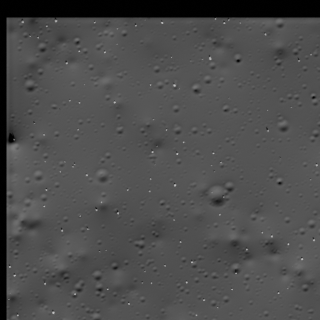

In [2]:
from PIL import Image
display(Image.open('tmp/render_tutorial/mesh_Haworth_final_adj_5mpp_surf_piece_0_5/terrain_00/rgb_000.png'))

Note that depending of how the sun orientation is set and sampled, the whole image might be black due to shadows from other parts of the terrain. 

In [1]:
display(Image.open('tmp/render_tutorial/mesh_Haworth_final_adj_5mpp_surf_piece_0_5/terrain_00/segmentation_color_001.png'))

NameError: name 'Image' is not defined

The dominant red color is the base mesh, and the turquoise color are the rocks

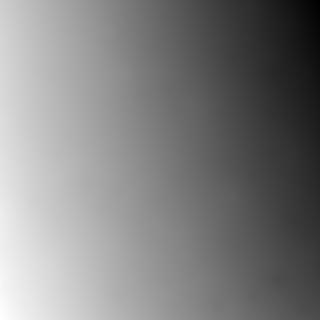

In [73]:
from PIL import Image
display(Image.open('tmp/render_tutorial/mesh_Haworth_final_adj_5mpp_surf_piece_0_5/terrain_00/depth_norm_001.png'))

To visualize the crater field, we can open crater_field.csv

In [74]:
!cat 'tmp/render_tutorial/mesh_Haworth_final_adj_5mpp_surf_piece_0_5/terrain_00/rock_field.csv'

23385.63s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


x,y,diameter,height,shape_type,rot_x,rot_y,rot_z,z_shift
-102.0793141506457,-221.68218583635175,1.2197268414237943,0.4857779485517241,10,0.11845973039177354,-0.17192676078569763,1.0453579602313359,-0.2456521984099388
-56.12413237533531,-56.998567799583554,1.0673730754709174,0.21243417221693195,1,-0.1798821040675696,0.11465964365856879,4.515950931701547,0.052532109028228254
211.8720185407409,75.35590660440607,1.494414354972733,0.3584344428041685,10,0.14740801014831667,-0.00036322143633010784,0.3547184579503898,-0.34782855174010435
-229.5211445626073,-221.5037625889281,1.022292567453213,0.43386058190310167,7,-0.08830418158241873,0.1966654939585935,5.051800165058371,-0.25703942987798845
-43.334766060577124,-248.15680177287285,1.00946711224935,0.12419019449390098,4,-0.012416013199580883,-0.16502293085559205,0.030228314351648255,0.0047030440859049
89.87060313205507,-208.68839533060174,2.3209530379162384,0.4846572836277062,11,-0.12427356451865404,0.028432761395852324,3.7799303027519144,-0.79

<Axes: xlabel='x', ylabel='y'>

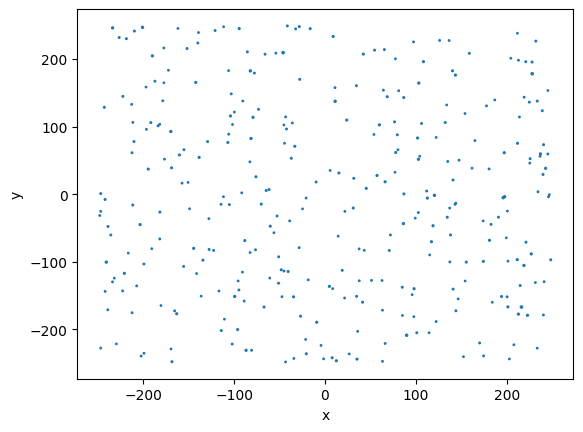

In [75]:
# open tmp/render_tutorial/mesh_Haworth_final_adj_5mpp_surf_piece_0_5/terrain_00/rock_field.csv
import pandas as pd
rock_field = pd.read_csv('tmp/render_tutorial/mesh_Haworth_final_adj_5mpp_surf_piece_0_5/terrain_00/rock_field.csv')
rock_field.plot.scatter(x='x', y='y', s=rock_field['diameter'])

Let's do the same with the craters

In [76]:
!cat 'tmp/render_tutorial/mesh_Haworth_final_adj_5mpp_surf_piece_0_5/terrain_00/crater_field.csv'

23444.41s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


x,y,diameter
96.60797145660688,445.61521004791723,1.47712008189741
493.36728995590977,297.65511439490024,3.026791105603121
273.3747870196887,371.87640908976385,1.0501668496124952
327.3228833140789,152.42177836340238,1.070123736704355
262.8828822953372,192.5116062222354,1.150607424506674
162.3850692078046,489.29016696643,1.6687774150230792
36.89130810891689,432.1505121902951,1.0325979582174558
148.1021101345652,307.5171703437131,1.6663595865860814
106.3747794766936,66.66169743955314,1.0736930696437965
473.502542831716,135.13832858691578,1.1130557826460137
442.4488447660582,118.55634380232682,1.8348364401555217
373.06762113122835,387.6865623970148,1.1731989518966883
463.97296574618025,38.38468411493873,1.0026546520659412
448.65011206570813,287.25097258933573,1.3552777895499668
259.93457199159076,306.6194180502142,1.1801146562136784
211.81310307581975,299.74348161780114,1.5337405779217606
442.0144502013444,164.7330048451613,1.010247975249159
186.2080408743618,213.67102915564863,1.51488676

<Axes: xlabel='x', ylabel='y'>

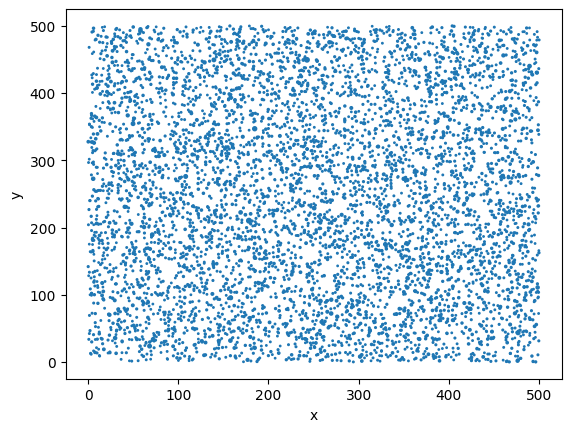

In [77]:
rock_field = pd.read_csv('tmp/render_tutorial/mesh_Haworth_final_adj_5mpp_surf_piece_0_5/terrain_00/crater_field.csv')
rock_field.plot.scatter(x='x', y='y', s=rock_field['diameter'])

Let's analyze the contents of params.json

In [78]:
!cat 'tmp/render_tutorial/mesh_Haworth_final_adj_5mpp_surf_piece_0_5/terrain_00/params.json'

23520.82s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


{
    "blend_file": "../../assets/base_meshes/Haworth_final_adj_5mpp_surf_piece_0_5.tif",
    "cases_config": {
        "cases": 2,
        "distributions": {
            "camera/ortho_scale": {
                "type": "fixed",
                "value": 320.0
            },
            "camera/x": {
                "max": -159.51511150598526,
                "min": 159.54205513000488,
                "type": "uniform"
            },
            "camera/y": {
                "max": -159.45487248897552,
                "min": 159.47238302230835,
                "type": "uniform"
            },
            "sun/azimuth": {
                "max": 6.28,
                "min": 0.0,
                "type": "uniform"
            },
            "sun/elevation": {
                "max": 0.2,
                "min": 0.1,
                "type": "uniform"
            }
        },
        "output_dir": "tmp/render_tutorial/mesh_Haworth_final_adj_5mpp_surf_piece_0_5/terrain_00"
    },
    "cases_confi

It includes the list of rendering settings distributions, and the value for each render. For orthographic cameras, we can plot the extent of the camera for each render.

In [79]:
# open params.json
import json
with open('tmp/render_tutorial/mesh_Haworth_final_adj_5mpp_surf_piece_0_5/terrain_00/params.json') as f:
    params = json.load(f)
cases_df = pd.DataFrame(params['cases_list'])
cases_df


,camera/ortho_scale,camera/pitch,camera/x,camera/y,camera/yaw,camera/z,case_id,files,sun/azimuth,sun/elevation,time_to_render
0,320.0,-1.570796,-96.732743,107.673970,0,251.087692,0,"[rgb_000.png, segmentation_color_000.png, dept...",0.165010,0.194836,1.093305
1,320.0,-1.570796,11.082629,-58.510733,0,251.087692,1,"[rgb_001.png, depth_norm_001.png, depth_001.ex...",1.781911,0.108005,0.781366


case: -96.73274269433892, 107.67396998039919, 320.0
case: 11.082629342266983, -58.51073329429795, 320.0


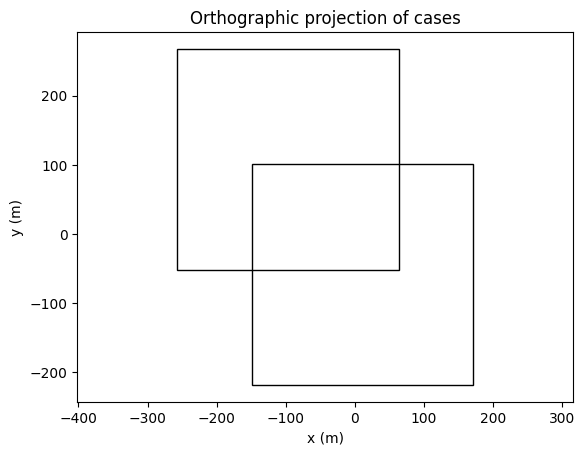

In [87]:
# plot the camera/x, camera/y, with a rectangle of size camera/ortho_scales
import matplotlib.pyplot as plt
import matplotlib.patches as patches
fig, ax = plt.subplots()
for case in params['cases_list']:
    print(f"case: {case['camera/x']}, {case['camera/y']}, {case['camera/ortho_scale']}")
    ax.add_patch(patches.Rectangle((case['camera/x'] - case['camera/ortho_scale']/2, case['camera/y'] - case['camera/ortho_scale']/2), case['camera/ortho_scale'], case['camera/ortho_scale'], edgecolor="black", facecolor="none",))
plt.axis("equal")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_title("Orthographic projection of cases")
plt.show()

Take a look to the report created with the script `generate_enhanced_moon_terrain_dataset_report.py` to see the distribution of the craters and rocks in the terrains

```bash
python generate_enhanced_moon_terrain_dataset_report.py
```
Once the report is created, you can open the file `report.html` in a browser to see the distribution of the craters and rocks in the terrains.

## Create a Rock Field

In [1]:
from lunasynth.terrain_enhancement import RockField
rock_field = RockField()
rock_field.generate(
        k=0.06,
        size_x=100,
        size_y=100,
        h_min=0.4,
        h_max=10,
        x_init=-100 / 2,
        y_init=-100 / 2,
)

Generated 645 values with CFA=4.39% in 7 iterations


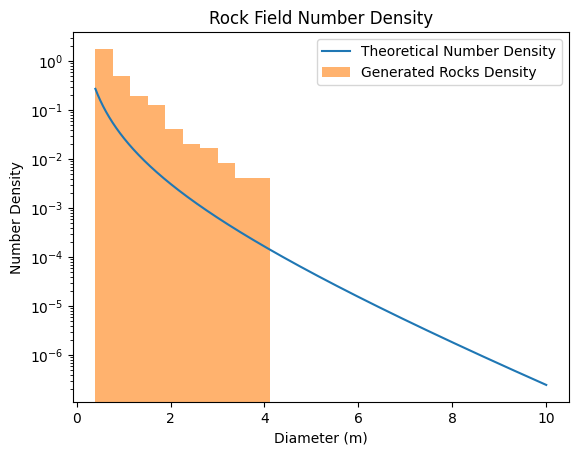

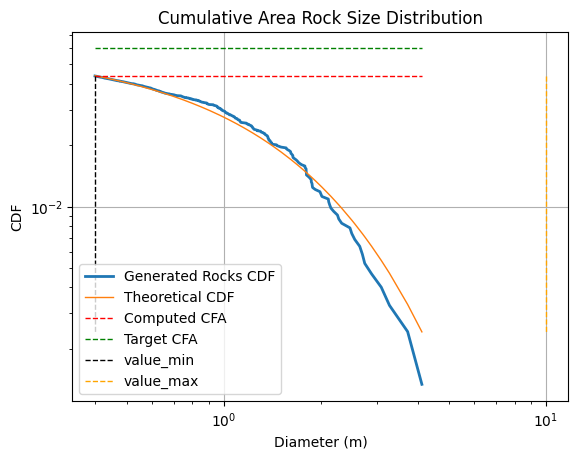

In [2]:
rock_field.cfa_model.plot_creation(show=True)
rock_field.cfa_model.plot_cum_rock_size(show=True)

See [playground](src/playground/rock_field_generation_playground.py) for an interactive example of how to create a rock field.

![picture 0](../../images/9585591bc69edf0d2103cbca2f6cba8c599db578fd2f33ce44ba4a4c35f8cc66.png)  


## Create a Crater Field

Text(0.5, 1.0, 'Crater profile')

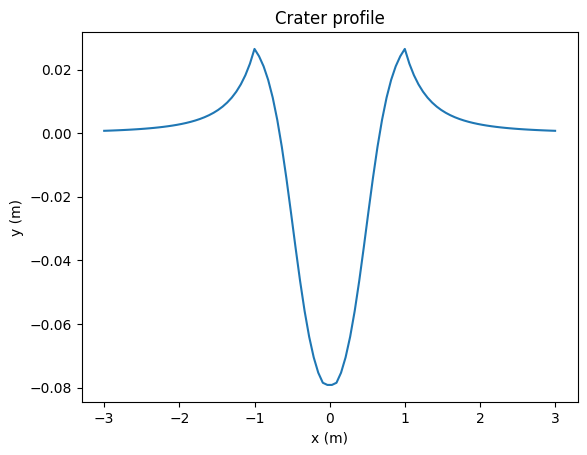

In [7]:
from lunasynth.terrain_enhancement import Crater
import numpy as np

crater = Crater(0,0,1)
xv = np.linspace(-3, 3, 100)
crater_profile = np.zeros_like(xv)

for i, x in enumerate(xv):
    crater_profile[i] = crater.crater_depth(abs(x))

from matplotlib import pyplot as plt
plt.plot(xv, crater_profile)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Crater profile")


Text(0.5, 1.0, 'Crater elevation')

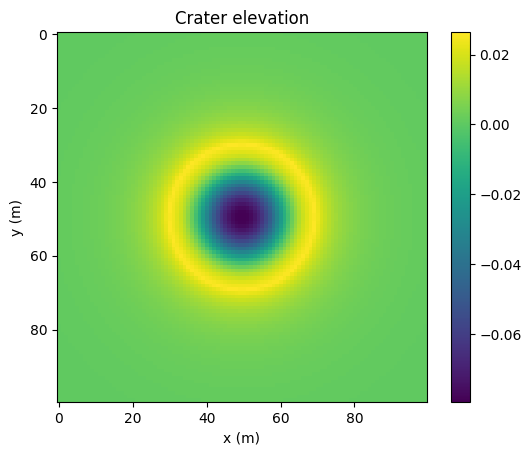

In [1]:
from lunasynth.terrain_enhancement import Crater
import numpy as np

crater = Crater(0,0,1)
crater_elevation, x, y = crater.compute_elevation_patch()


from matplotlib import pyplot as plt
plt.imshow(crater_elevation)
plt.colorbar()
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Crater elevation")

## Define Rendering Cases


```yaml
  <object>/<property>:
    type: "uniform" | "normal" | "fixed" | "list" | "grid"
    <distribution_property> : <distribution_value>
```
Supported distributions:
- `uniform`: Uniform distribution, requires `min` and `max` properties
- `normal`: Normal distribution, requires `mean` and `std` properties
- `fixed`: Fixed value for all cases, requires `value` property
- `list`: List of values to make a random selection each case, requires `values` property
- `grid`: Grid of values to sample, requires `min`, `max`, and `n_values` properties

If more than one grid is defined, the Cartesian product of the grids will be used to sample the parameters. If the number of cases is smaller than all combinations of grid parameters, the number of cases will be set the required size to fill at least one grid sampling. The rest of the parameters will be sampled according to their distribution. 

Available objects with properties:
- `sun/azimuth`: Azimuth of the sun in radians
- `sun/elevation`: Elevation of the sun with respect of ground in radians
- `camera/fov`: Field of view of the camera in degrees
- `camera/x`: x position of the camera
- `camera/y`: y position of the camera
- `camera/z`: z position of the camera
- `camera/pitch`: pitch of the camera in radians
- `camera/yaw`: yaw of the camera in radians
- `camera/roll`: roll of the camera in radians

Example to set the azimuth of the sun ranging from 0 to 2pi:
```yaml
  sun/azimuth:
    type: "uniform"
    min: 0.0
    max: 6.28
```

![](../../docs/sampling_grid_3d.png)

Example of a sampling grid in 3D space. The x, y and z are sampled in a grid, and the rest of the parameters are sampled from a uniform distribution.

![](../../docs/sampling_grid_2d_grid_side.png) 

![](../../docs/sampling_grid_2d_grid.png)


## Render a Trajectory
This case is similar to render a list of camera poses, but the main difference is that the sun does not change between poses. Once the render case list is generated, it is processed in the same way as the previous case.

To illustrate this case, we will the trajectory generated using generate_dummy_traj_landing.py:

         t  camera_x  camera_y  camera_z  camera_pitch  camera_yaw
0      1.0     0.300       0.0      12.0     -1.570796         0.0
1      2.0     0.432       0.0      14.0     -1.570796         0.0
2      3.0     0.588       0.0      16.0     -1.570796         0.0
3      4.0     0.768       0.0      18.0     -1.570796         0.0
4      5.0     0.972       0.0      20.0     -1.570796         0.0
..     ...       ...       ...       ...           ...         ...
195  196.0   480.000       0.0     402.0     -1.570796         0.0
196  197.0   484.812       0.0     404.0     -1.570796         0.0
197  198.0   489.648       0.0     406.0     -1.570796         0.0
198  199.0   494.508       0.0     408.0     -1.570796         0.0
199  200.0   499.392       0.0     410.0     -1.570796         0.0

[200 rows x 6 columns]


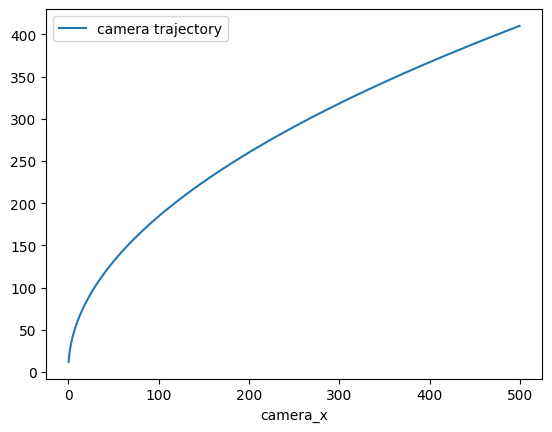

In [18]:
!python ../generate_dummy_traj_landing.py # it will save the trajectory in a file called "trajectory.csv"
import pandas as pd
df = pd.read_csv("trajectory.csv")
df.plot(x="camera_x", y="camera_z", label="camera trajectory")
print(df)

Before creating the renderin case list, we need to provide the sun direction in a scene file, here is the example of the scene file:

In [12]:
!cat ../../config/sun_scene.yaml

sun_elevation: 0.1
sun_azimuth: 0.0
depth_output: true
segmentation_output: true

In [35]:
!python ../lunasynth/cli/generate_traj_definition.py --trajectory trajectory.csv --scene ../../config/sun_scene.yaml --output trajectory_scene.json 
!yq -p=json trajectory_scene.json

20420.66s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
20426.22s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[WARNING] 02:08:17 yq default output is now 'auto' (based on the filename extension). Normally yq would output 'json', but for backwards compatibility 'yaml' has been set. Please use -oy to specify yaml, or drop the -p flag.
scene:
  depth_output: true
  segmentation_output: true
  sun_azimuth: 0
  sun_elevation: 0.1
trajectory:
  - camera_pitch: -1.5707963267948963
    camera_x: 0.3
    camera_y: 0
    camera_yaw: 0
    camera_z: 12
    t: 1
  - camera_pitch: -1.5707963267948963
    camera_x: 0.4320000000000001
    camera_y: 0
    camera_yaw: 0
    camera_z: 14
    t: 2
  - camera_pitch: -1.5707963267948963
    camera_x: 0.5880000000000001
    camera_y: 0
    camera_yaw: 0
    camera_z: 16
    t: 3
  - camera_pitch: -1.5707963267948963
    camera_x: 0.768
    camera_y: 0
    camera_yaw: 0
    camera_z: 18
    t: 4
  - camera_pitch: -1.5707963267948963
    camera_x: 0.972
    camera_y: 0
    camera_yaw: 0
    camera_z: 20
    t: 5
  - camera_pitch: -1.5707963267948963
    camera_x: 1.2

Now we can generate cases process traj cases. To show the output, we run it here with flag --dry-run. Remove the flag to generate render the trajectory. It needs a blender file so we just provide the one for unit testing

In [36]:
!python ../lunasynth/cli/process_traj_cases.py ../../tests/resources/test_load_rocks.blend --config trajectory_scene.json --output-dir tmp/traj_cases --dry-run
!yq -p=json tmp/traj_cases/params.json

20462.46s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Saving cases description to tmp/traj_cases
Cases description saved to tmp/traj_cases


20468.54s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[WARNING] 02:08:59 yq default output is now 'auto' (based on the filename extension). Normally yq would output 'json', but for backwards compatibility 'yaml' has been set. Please use -oy to specify yaml, or drop the -p flag.
blend_file: ../../tests/resources/test_load_rocks.blend
cases_config:
  depth_output: true
  output_dir: tmp/traj_cases
  scene:
    depth_output: true
    segmentation_output: true
    sun_azimuth: 0
    sun_elevation: 0.1
  segmentation_output: true
  trajectory:
    - camera_pitch: -1.5707963267948963
      camera_x: 0.3
      camera_y: 0
      camera_yaw: 0
      camera_z: 12
      t: 1
    - camera_pitch: -1.5707963267948963
      camera_x: 0.4320000000000001
      camera_y: 0
      camera_yaw: 0
      camera_z: 14
      t: 2
    - camera_pitch: -1.5707963267948963
      camera_x: 0.5880000000000001
      camera_y: 0
      camera_yaw: 0
      camera_z: 16
      t: 3
    - camera_pitch: -1.5707963267948963
      camera_x: 0.768
      camera_y: 0
      camera_ya

We can open the cases and check they follow the preescribed trajectory.

<Axes: xlabel='camera/x'>

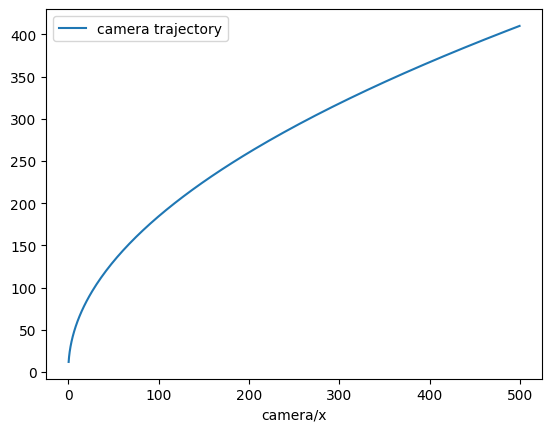

In [29]:
import json
with open("tmp/traj_cases/params.json") as f:
    params = json.load(f)
df = pd.DataFrame(params["cases_list"])
df.plot(x="camera/x", y="camera/z", label="camera trajectory")